## Binary Classification Problem with Target values either 0 or 1

Connect to google drive for dataset reading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install catboost

Import libraries for importing data, visualization and EDA

In [ ]:
import pandas as pd, numpy as np, time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

# to impute the missing values
from sklearn.impute import SimpleImputer

from scipy import stats
from scipy.stats import norm, skew

%matplotlib inline
sns.set(color_codes=True)

from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Boosting Algorithms :
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost  import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


Set the path path of the data set, which will be referred down the line to access the train/test data.

Also same path will use to store the submission file at the ned of the mdoel run

In [ ]:
dataSetPath = '/content/gdrive/My Drive/Colab Notebooks/KaggleDatasets/NovartisDataSet'

Read train and test data into the dataframe

In [ ]:
dfTrain = pd.read_csv(dataSetPath + '/NovartisMaliciousTrain.csv')
dfTest = pd.read_csv(dataSetPath + '/NovartisMaliciousTest.csv')

In next 4 lines will see the shape and first 5 rows of the train and test data sets

In [ ]:
dfTrain.shape

(23856, 18)

In [ ]:
dfTest.shape

(15903, 17)

In [ ]:
dfTrain.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [ ]:
dfTest.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


Info on dataframe will help us know the number of rows, columns and the data types of each column

In [ ]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   INCIDENT_ID       23856 non-null  object 
 1   DATE              23856 non-null  object 
 2   X_1               23856 non-null  int64  
 3   X_2               23856 non-null  int64  
 4   X_3               23856 non-null  int64  
 5   X_4               23856 non-null  int64  
 6   X_5               23856 non-null  int64  
 7   X_6               23856 non-null  int64  
 8   X_7               23856 non-null  int64  
 9   X_8               23856 non-null  int64  
 10  X_9               23856 non-null  int64  
 11  X_10              23856 non-null  int64  
 12  X_11              23856 non-null  int64  
 13  X_12              23674 non-null  float64
 14  X_13              23856 non-null  int64  
 15  X_14              23856 non-null  int64  
 16  X_15              23856 non-null  int64 

Check if any columns is having null values, if yes then we will have to impute them based on different strategies

In [ ]:
dfTrain.isnull().any()

INCIDENT_ID         False
DATE                False
X_1                 False
X_2                 False
X_3                 False
X_4                 False
X_5                 False
X_6                 False
X_7                 False
X_8                 False
X_9                 False
X_10                False
X_11                False
X_12                 True
X_13                False
X_14                False
X_15                False
MULTIPLE_OFFENSE    False
dtype: bool

We can see that column X_12 has null values, rest all columns seems have all data

Let's first get rid of the NaN values in the column X_12

We can see the value 1.0 is highest in count, and also the data is skewed a lot, with max being 90 whereas the median is 1.0
So to fill missing values let's use mode() to achieve it

In [ ]:
# create a copy of datasets

dfNonBlankTrain = dfTrain.copy()
dfNonBlankTest = dfTest.copy()

Based on the data present in the X-12 column high % of data belongs to "1"

So imputing the missing value with MODE

In [ ]:
# X_12 column
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dfNonBlankTrain['X_12'] = imputer.fit_transform(dfNonBlankTrain[['X_12']])
dfNonBlankTest['X_12'] = imputer.fit_transform(dfNonBlankTest[['X_12']])

In [ ]:
dfNonBlankTrain.describe().T

,count,mean,std,min,25%,50%,75%,max
X_1,23856.0,0.483778,1.439738,0.0,0.0,0.0,0.0,7.0
X_2,23856.0,24.791206,15.240231,0.0,7.0,24.0,36.0,52.0
X_3,23856.0,24.637450,15.135093,0.0,8.0,24.0,35.0,52.0
X_4,23856.0,4.276744,2.944672,0.0,2.0,4.0,6.0,10.0
X_5,23856.0,2.455609,1.963095,0.0,1.0,3.0,5.0,5.0
X_6,23856.0,6.154175,4.471756,1.0,3.0,5.0,8.0,19.0
X_7,23856.0,4.876509,3.881931,0.0,2.0,4.0,7.0,18.0
X_8,23856.0,0.972460,1.453144,0.0,0.0,1.0,1.0,99.0
X_9,23856.0,4.924128,1.362625,0.0,5.0,5.0,6.0,6.0
X_10,23856.0,1.244802,1.119301,1.0,1.0,1.0,1.0,90.0


The 'Date' Column:

Data Cleaning & Feature Engineering:

In [ ]:
# # check for missing value
# dfNonBlankTrain.DATE.isnull().any(), dfNonBlankTest.DATE.isnull().any()

In [ ]:
# dfNonBlankTrain['DATE'] = pd.to_datetime(dfNonBlankTrain['DATE'])
# dfNonBlankTest['DATE'] = pd.to_datetime(dfNonBlankTest['DATE'])

In [ ]:
# dfNonBlankTrain['DATE'] = pd.to_datetime(dfNonBlankTrain['DATE'], format='%Y-%m-%d')
# dfNonBlankTest['DATE'] = pd.to_datetime(dfNonBlankTest['DATE'], format='%Y-%m-%d')


Create separate columns for 'Year', 'Month', 'Day'

In [ ]:
# dfNonBlankTrain['Year'] = dfNonBlankTrain.DATE.dt.year
# dfNonBlankTrain['Year'].sample(3)

In [ ]:
# dfNonBlankTest['Year'] = dfNonBlankTest.DATE.dt.year
# dfNonBlankTest['Year'].sample(3)

In [ ]:
# dfNonBlankTrain['Month'] = dfNonBlankTrain.DATE.dt.month
# dfNonBlankTrain['Month'].sample(3)

In [ ]:
# dfNonBlankTest['Month'] = dfNonBlankTest.DATE.dt.month
# dfNonBlankTest['Month'].sample(3)

In [ ]:
# dfNonBlankTrain['Day'] = dfNonBlankTrain.DATE.dt.day
# dfNonBlankTrain['Day'].sample(3)

In [ ]:
# dfNonBlankTest['Day'] = dfNonBlankTest.DATE.dt.day
# dfNonBlankTest['Day'].sample(3)

In [ ]:
# dfNonBlankTrain.DATE.dt.dayofweek.head()

In [ ]:
# dfNonBlankTrain['DayOfWeek'] = dfNonBlankTrain.DATE.dt.dayofweek
# dfNonBlankTrain['DayOfWeek'].sample(3)

In [ ]:
# dfNonBlankTest['DayOfWeek'] = dfNonBlankTest.DATE.dt.dayofweek
# dfNonBlankTest['DayOfWeek'].sample(3)

In [ ]:
# dfNonBlankTrain.sample(3)

In [ ]:
# dfNonBlankTest.sample(3)

In [ ]:
# dfNonBlankTrain.info()

Let's Check the range of Dates:

In [ ]:
# dfNonBlankTrain.DATE.min(), dfNonBlankTrain.DATE.max()

Malaciuos Attacks per Year visualization

In [ ]:
# malaciousYear = dfNonBlankTrain.groupby('Year')['MULTIPLE_OFFENSE'].count()
# malaciousYear

In [ ]:
# plt.figure(figsize=(20, 10))
# ax = malaciousYear.plot(kind='line', xticks=malaciousYear.index.values)
# ax.set_ylabel('Count of MULTIPLE_OFFENSE')

Malaciuos Attacks per Day Of Week visualization

In [ ]:
# for y in dfNonBlankTrain.Year.unique():
#     dfNonBlankTrain[dfNonBlankTrain['Year'] == y].groupby('DayOfWeek')['MULTIPLE_OFFENSE'].count().sort_values().plot(kind='barh', 
#                                                                                                               title=f'Count of Malaciuos Attacks per Day ({y})', 
#                                                                                                               fig=(16,5))
#     plt.show()

Malaciuos Attacks per Month visualization

In [ ]:
# for y in dfNonBlankTrain.Year.unique():
#     dfNonBlankTrain[dfNonBlankTrain['Year'] == y].groupby('Month')['MULTIPLE_OFFENSE'].count().sort_values().plot(kind='barh', 
#                                                                                                           title=f'Count of Malaciuos Attacks per Month ({y})', 
#                                                                                                           fig=(16,5))
#     plt.show()

In [ ]:
# for y in dfNonBlankTrain.Year.unique():
#     ax = dfNonBlankTrain[dfNonBlankTrain['Year'] == y].groupby('MULTIPLE_OFFENSE')['Year'].count().sort_values().plot(kind='bar', 
#                                                                                                                       title=f'Count of Malacious Attacks per Hour ({y})', 
#                                                                                                                       fig=(18,7))
#     plt.show()

### About the Target Column

In [ ]:
# Let us look at the target column which is 'Target' to understand how the data is distributed amongst the various classes
dfNonBlankTrain.groupby(["MULTIPLE_OFFENSE"])["MULTIPLE_OFFENSE"].count()

MULTIPLE_OFFENSE
0     1068
1    22788
Name: MULTIPLE_OFFENSE, dtype: int64

Highly unbalanced data

To make it easy to understand if a classifier were to train with this data set trying to achieve the best accuracy possible it would most likely label every transaction as a YES Target

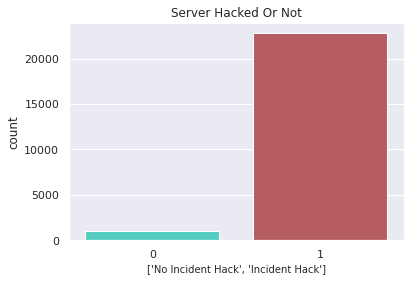

In [ ]:
# Check Target variables that has 0 value for No Incident Hack and 1 for Incident Hack
sns.countplot('MULTIPLE_OFFENSE',data=dfNonBlankTrain,palette=['turquoise','r'])
plt.title('Server Hacked Or Not')
plt.xlabel(['No Incident Hack', 'Incident Hack'], fontsize=10)
plt.show()

In [ ]:
trainDf = dfNonBlankTrain.copy()
testDf = dfNonBlankTest.copy()

### Let's remove outliers from the dataset based in IQR approach

In [ ]:
def outliers_iqr(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((data > upper_bound) | (data < lower_bound))

In [ ]:
Q1 = trainDf.quantile(0.25)
Q3 = trainDf.quantile(0.75)
IQR = Q3 - Q1
print('No. of outliers in all the fields: ',((trainDf < (Q1 - 1.5 * IQR)) | (trainDf > (Q3 + 1.5 * IQR))).sum())

No. of outliers in all the fields:  DATE                   0
INCIDENT_ID            0
MULTIPLE_OFFENSE    1068
X_1                 4820
X_10                3658
X_11                2692
X_12                8000
X_13                2078
X_14                   0
X_15                4909
X_2                    0
X_3                    0
X_4                    0
X_5                    0
X_6                  894
X_7                  574
X_8                 1804
X_9                 3785
dtype: int64


In [ ]:
trainDf['X_12'] = trainDf['X_12'].astype('int64') 
testDf['X_12'] = testDf['X_12'].astype('int64') 
trainDf['MULTIPLE_OFFENSE'] = trainDf['MULTIPLE_OFFENSE'].astype('category') 

In [ ]:
#Drop Duplicate rows

trainDf = trainDf.drop(['INCIDENT_ID', 'DATE'], axis=1)

trainDf.drop_duplicates(keep='first', inplace=True)

trainDf.shape

(18814, 16)

Feature Selection 

In [ ]:
trainDf.columns

Index(['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10',
       'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'MULTIPLE_OFFENSE'],
      dtype='object')

In [ ]:
testDf.columns

Index(['INCIDENT_ID', 'DATE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15'],
      dtype='object')

In [ ]:
feature_cols = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
                'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15']

target_col = 'MULTIPLE_OFFENSE'

train_x = trainDf[feature_cols]
train_y = trainDf[target_col]

test_ids = testDf['INCIDENT_ID']
test_x = testDf[feature_cols]

In [ ]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(train_x, train_y)
print(train_x.shape, ' ', train_y.shape)
print(X_over.shape, ' ', y_over.shape)

(18814, 15)   (18814,)
(35672, 15)   (35672,)


Split the data into train test

In [ ]:
# X_train, X_test, y_train, y_test= train_test_split(train_x, train_y, test_size=0.3, random_state=22, shuffle = True, stratify = train_y)
X_train, X_val, y_train, y_val = train_test_split(X_over, y_over, test_size=0.3, random_state=22, shuffle = True, stratify = y_over)

In [ ]:
print(X_train.shape, ' ', y_train.shape)
print(X_val.shape,   ' ', y_val.shape)

(24970, 15)   (24970,)
(10702, 15)   (10702,)


In [ ]:
#Use standardscaler to standardize the features

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc   = sc.transform(X_val)

In [ ]:
#Use standardscaler to standardize the features
X_test_sc = sc.transform(test_x)

In [ ]:
#CATBoost

from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(learning_rate=0.1, n_estimators=1000, subsample=0.70, max_depth=5, scale_pos_weight=2.5, silent=True)
cb_clf.fit(X_train_sc, y_train)

# evaluate predictions
y_train_predict_cb = cb_clf.predict(X_train_sc)
print('Train Accuracy %.3f' % metrics.accuracy_score(y_train, y_train_predict_cb))

# make predictions for test data
y_pred_cb = cb_clf.predict(X_val_sc)
predictions = [round(value) for value in y_pred_cb]

print('Test Accuracy %.3f' % metrics.accuracy_score(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))
print(metrics.classification_report(y_val, predictions))
print('Precision Score %.3f' % metrics.precision_score(y_val, predictions))
print('Recall Score %.3f' % metrics.recall_score(y_val, predictions))
print('F1 Score %.3f' % metrics.f1_score(y_val, predictions))

Train Accuracy 1.000
Test Accuracy 1.000
[[5351    0]
 [   2 5349]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5351
           1       1.00      1.00      1.00      5351

    accuracy                           1.00     10702
   macro avg       1.00      1.00      1.00     10702
weighted avg       1.00      1.00      1.00     10702

Precision Score 1.000
Recall Score 1.000
F1 Score 1.000


In [ ]:
predict_test_cb = cb_clf.predict(X_test_sc)
submission_df = pd.DataFrame({'INCIDENT_ID':test_ids, 'MULTIPLE_OFFENSE':predict_test_cb})
submission_df.to_csv(dataSetPath + '/sample_submission.csv', index=False)

With above cat boost model got 99.41026 score on leader board

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import VotingClassifier

import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 42

clf1 = XGBClassifier(n_estimators=1000, scale_pos_weight = 2.5, silent=True)

clf2 = CatBoostClassifier(silent=True, learning_rate=0.1, n_estimators=1000, scale_pos_weight=2.5)
                                                                                           
clf3 = LGBMClassifier(objective ="binary",verbosity = -1, learning_rate=0.1, n_estimators=1000, scale_pos_weight=2.5)

clf4 = GradientBoostingClassifier(min_samples_split= 4, max_depth=5, n_estimators=1000, subsample=0.70)
 
lr = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], meta_classifier=lr)

for clf, label in zip([clf1, clf2, clf3, clf4, sclf], 
                      ['XGBClassifier', 
                       'CatBoostClassifier', 
                       'LGBMClassifier',
                       'GradientBoostingClassifier',
                       'StackingCVClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

# Fit on train data / predict on test data
sclf_fit = sclf.fit(X_train, y_train)
y_pred_st = sclf.predict(X_val)

Accuracy: 1.00 (+/- 0.00) [XGBClassifier]
Accuracy: 1.00 (+/- 0.00) [CatBoostClassifier]
Accuracy: 1.00 (+/- 0.00) [LGBMClassifier]
Accuracy: 1.00 (+/- 0.00) [GradientBoostingClassifier]
Accuracy: 1.00 (+/- 0.00) [StackingCVClassifier]


In [ ]:
print('Test Accuracy %.3f' % metrics.accuracy_score(y_val, y_pred_st))
print(metrics.confusion_matrix(y_val, y_pred_st))
print(metrics.classification_report(y_val, y_pred_st))
print('Precision Score %.3f' % metrics.precision_score(y_val, y_pred_st))
print('Recall Score %.3f' % metrics.recall_score(y_val, y_pred_st))
print('F1 Score %.3f' % metrics.f1_score(y_val, y_pred_st))

Test Accuracy 1.000
[[5351    0]
 [   2 5349]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5351
           1       1.00      1.00      1.00      5351

    accuracy                           1.00     10702
   macro avg       1.00      1.00      1.00     10702
weighted avg       1.00      1.00      1.00     10702

Precision Score 1.000
Recall Score 1.000
F1 Score 1.000


In [ ]:
predict_test_stack = sclf.predict(X_test_sc)
submission_df = pd.DataFrame({'INCIDENT_ID':test_ids, 'MULTIPLE_OFFENSE':predict_test_stack})
submission_df.to_csv(dataSetPath + '/sample_submission.csv', index=False)

Worst performance of 50.23 recall score

In [ ]:
# lets implement voting classifier and see how much the recall improves

clf1 = XGBClassifier(n_estimators=900, scale_pos_weight = 2.5, silent=True)

clf2 = CatBoostClassifier(silent=True, learning_rate=0.1, n_estimators=900, scale_pos_weight=2.5)

clfVC   = VotingClassifier(estimators=[('XGB', clf1),('CBC', clf2)],  voting='hard')

scores = model_selection.cross_val_score(clfVC, X_train_sc, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) " % (scores.mean(), scores.std() ))

clfVC.fit(X_train_sc, y_train)

# evaluate predictions
y_train_predict_vot = clfVC.predict(X_train_sc)
print('Train Accuracy %.3f' % metrics.accuracy_score(y_train, y_train_predict_vot))

# make predictions for test data
y_pred_clfVC = clfVC.predict(X_val_sc)
predictions = [round(value) for value in y_pred_clfVC]

print('Test Accuracy %.3f' % metrics.accuracy_score(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))
print(metrics.classification_report(y_val, predictions))
print('Precision Score %.3f' % metrics.precision_score(y_val, predictions))
print('Recall Score %.3f' % metrics.recall_score(y_val, predictions))
print('F1 Score %.3f' % metrics.f1_score(y_val, predictions))


Accuracy: 1.00 (+/- 0.00) 
Train Accuracy 1.000
Test Accuracy 1.000
[[5351    0]
 [   2 5349]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5351
           1       1.00      1.00      1.00      5351

    accuracy                           1.00     10702
   macro avg       1.00      1.00      1.00     10702
weighted avg       1.00      1.00      1.00     10702

Precision Score 1.000
Recall Score 1.000
F1 Score 1.000


In [ ]:
predict_test_stack = clfVC.predict(X_test_sc)
submission_df = pd.DataFrame({'INCIDENT_ID':test_ids, 'MULTIPLE_OFFENSE':predict_test_stack})
submission_df.to_csv(dataSetPath + '/sample_submission.csv', index=False)

Score approached 99.68